จัดการ Parameter ของโมเดล และสร้าง Optimizer สำหรับอัพเดท Parameter ตามอัลกอริทึมต่าง ๆ โดย[เริ่มต้น Refactor ที่หัวข้อ 6](#6.-Refactor-Model-Parameter)

# 0. Magic

In [112]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Import

In [0]:
import torch
from torch import tensor
from torch import nn
import torch.nn.functional as F
from torch.utils import data 
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
from fastai.metrics import accuracy
import pickle, gzip, math, torch
import operator

# 2. Data

In [0]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [0]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

In [0]:
x_train, y_train, x_valid, y_valid = get_data()

# 3. เตรียม Data

In [0]:
class Dataset(data.Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [0]:
# x = data, m = mean, s = standard deviation
def normalize(x, m, s): 
    return (x-m)/s

In [190]:
n, m = x_train.shape
c = y_train.max()+1
n, m, c

(50000, 784, tensor(10))

In [0]:
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [0]:
# batch size
bs = 64
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
train_dl, valid_dl = data.DataLoader(train_ds, bs), data.DataLoader(valid_ds, bs)

# 4. สร้าง Model

โมเดลจะประกอบด้วยส่วนต่าง ๆ เช่น Architecture กำหนด Layers ต่าง ๆ, Initialization, Loss Function, อัลกอริทึมในการเทรน และ Metrics ที่เราเรียนรู้กันไปใน ep ก่อน ๆ 

โมเดล

In [0]:
class Model(nn.Module):
    # number of input feature, number of hidden feature, number of output feature
    def __init__(self, n_in, nh, n_out):
        super().__init__()
#         set_trace()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [0]:
def get_model():
    # loss function
    loss_func = F.cross_entropy
    model = Model(m, nh, c.numpy())
    return model, loss_func

กำหนด Hyperparameter

In [0]:
# learning rate
lr = 0.03
epoch = 1
nh = 50

# 5. Training Loop

เราจะเทรนโมเดล ด้วยอัลกอริทึม [Stochastic Gradient Descent (SGD)](https://www.bualabs.com/wp-admin/post.php?post=631&action=edit) และ เก็บ Loss, Accuracy เอาไว้พล็อตกราฟ

ประกาศฟังก์ชัน fit เอาไว้เรียกเทรนเวลาที่ต้องการ

In [0]:
def fit():
    losses, metrics = [], []
    # e = epoch number
    for e in range(epoch):
        for xb, yb in train_dl:

            # Feedforward
            yhatb = model(xb)
            loss = loss_func(yhatb, yb)

            # Metrics
            acc = accuracy(yhatb, yb)
            losses.append(loss); metrics.append(acc)

            # Backpropagation
            loss.backward()

            # Update Wight and Bias with SGD
            with torch.no_grad():
                for l in model.layers:
                    if hasattr(l, 'weight'):
                        l.weight -= l.weight.grad * lr
                        l.bias   -= l.bias.grad * lr 
                        l.weight.grad.zero_()
                        l.bias.grad.zero_()       

    plot_metrics(losses, metrics)

ประการฟัง์ชัน ไว้พล็อตกราฟ Loss และ Accuracy

In [0]:
def plot_metrics(losses, metrics):
    x = torch.arange(len(losses)).numpy()
    fig,ax = plt.subplots(figsize=(9, 9))
    ax.grid(True)
    ax.plot(x, losses, label="Loss")
    ax.plot(x, metrics, label="Accuracy")
    ax.legend(loc='upper right')

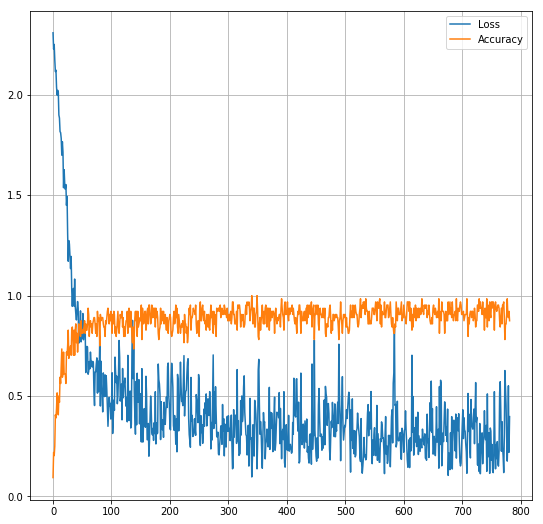

In [198]:
model, loss_func = get_model()
fit()

# 6. Refactor Model Parameter

ก่อนหน้านี้ Layer ทั้งหมด จะเป็น List ใน Instance Variable ชื่อ layers เราจะ Refactor แต่ละ Layer ให้เป็น Instance Variable ของโมเดลโดยตรง เพื่อที่เราจะ Iterate Parameter ออกมาอัพเดทได้สะดวกขึ้น

In [199]:
model

Model()

In [200]:
model.layers

[Linear(in_features=784, out_features=50, bias=True),
 ReLU(),
 Linear(in_features=50, out_features=10, bias=True)]

In [0]:
class Model2(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    def __call__(self, x):
        return self.l2(F.relu(self.l1(x)))
        

ตอนอัพเดท Parameter เปลี่ยนไปเรียกจาก model.parameters แทน

In [0]:
def fit2():
    losses, metrics = [], []
    # e = epoch number
    for e in range(epoch):
        for xb, yb in train_dl:

            # Feedforward
            yhatb = model(xb)
            loss = loss_func(yhatb, yb)

            # Metrics
            acc = accuracy(yhatb, yb)
            losses.append(loss); metrics.append(acc)

            # Backpropagation
            loss.backward()

            # Update Wight and Bias with SGD
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                    p.grad.zero_()

    plot_metrics(losses, metrics)

In [0]:
model = Model2(m, nh, c.numpy())

ถ้าเป็น Instance Variable เราสามารถ Access โดยใช้ .named_children()

In [204]:
for name, l in model.named_children(): print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [205]:
model

Model2(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

## 6.1 Register Module ด้วยตัวเอง

ข้างบนเราสามาถเรียก model.named_childen และ print model แสดงแต่ละ Layer ออกมาได้ เนื่องจากภายใน nn.Module จะ Override \_\_setattr__ เพื่อ Register Submodule ที่เราประกาศให้โดยอัตโนมัติ ใน Instance Variable self.\_modules ดังตัวอย่างโค้ดด้านล่าง



In [0]:
class Model3():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)

    # k = key, v = value
    def __setattr__(self, k, v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k, v)
    
    def __repr__(self): return f"{self._modules}"

    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters():
                yield p

In [207]:
model = Model3(m, nh, c.numpy())
for p in model.parameters(): print(f'{p.shape}')

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


## 6.2 Register Module จาก List

แต่การประกาศ Layer เป็น Instance Variable ทำให้โมเดลไม่ยืดหยุ่น ไม่สามารถเพิ่ม Layer ได้แบบ Dynamic เราจะใช้ List layers แบบเดิมก็แต่ แต่ต้อง Register Module เอง ด้วย nn.Module.add_module()

In [0]:
class Model4(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
    
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x


In [209]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,c.numpy())]
model = Model4(layers)
model

Model4(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [210]:
for p in model.parameters(): print(f'{p.shape}')

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


## 6.3 Refactor ไปใช้ nn.ModuleList

ใช้ nn.ModuleList ในการช่วย Register Module

In [0]:
class Model5(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
    
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x


In [212]:
model = Model5(layers)
model

Model5(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [213]:
for p in model.parameters(): print(f'{p.shape}')

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


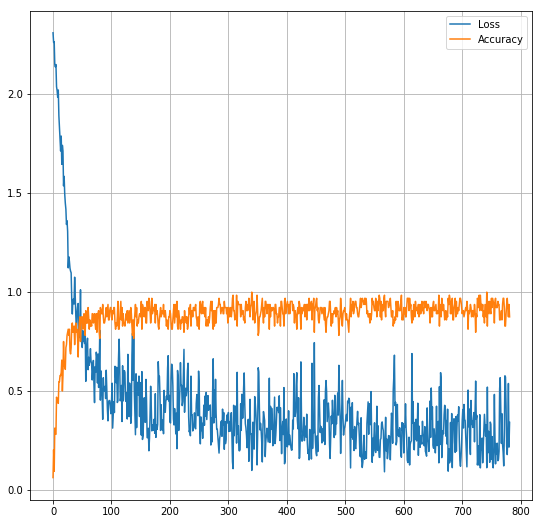

In [214]:
fit2()

## 6.4 nn.Sequential

ที่ทำมาทั้งหมด คือ nn.Sequential

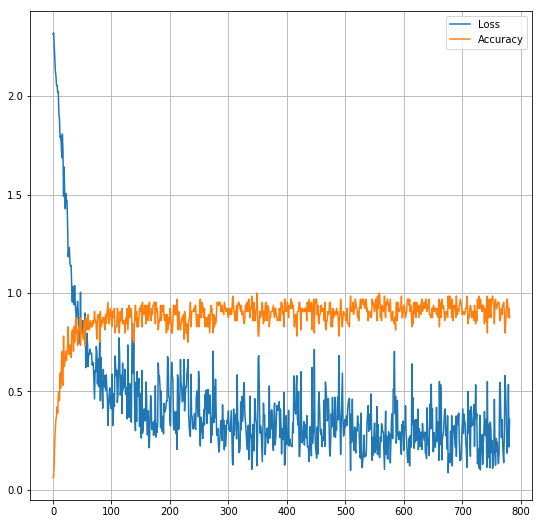

In [215]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,c.numpy()))
fit2()

# 7. Optim

เราจะ Refactor ส่วนอัพเดท Parameter Training Loop ออกมาไว้ข้างนอก สร้างเป็น Class ใหม่ เรียกว่า optim (Optimzation) เพื่อที่เราจะใช้ Optimzation Algorithm ต่าง ๆ ได้โดยไม่ต้องกลับไปแก้โค้ด Training Loop

Before
```
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                    p.grad.zero_()
```

After
```
            optim.step()
            optim.zero_grad()
```

ที่เราต้องแยก step และ zero_grad เนื่องจากยืดหยุ่นกว่า ตัวอย่างเช่น ในบางเคสที่โมเดลมี Grad น้อยมาก เราอาจจะไม่ต้องการ Clear Grad ทุกครั้งที่ step

## 7.1 Optimizer

In [0]:
class Optimizer():
    # params = parameters of model, lr = learning rate
    def __init__(self, params, lr=0.5): self.params, self.lr = list(params), lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                p -= p.grad * self.lr 

    def zero_grad(self):
        for p in self.params: p.grad.zero_()

Training Loop ใหม่ ที่ใช้ optim

In [0]:
def fit3():
    losses, metrics = [], []
    # e = epoch number
    for e in range(epoch):
        for xb, yb in train_dl:

            # Feedforward
            yhatb = model(xb)
            loss = loss_func(yhatb, yb)

            # Metrics
            acc = accuracy(yhatb, yb)
            losses.append(loss); metrics.append(acc)

            # Backpropagation
            loss.backward()

            optim.step()
            optim.zero_grad()

    plot_metrics(losses, metrics)

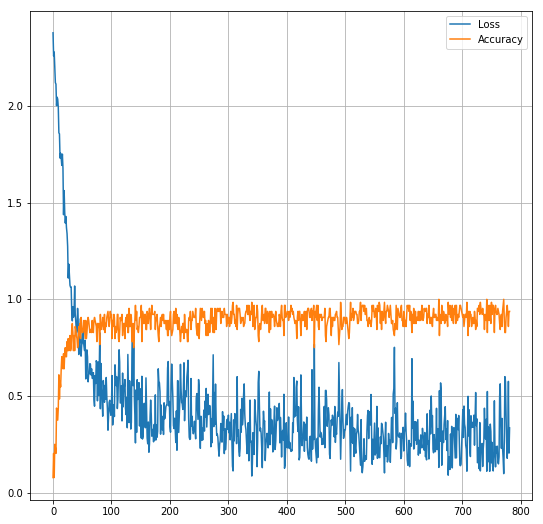

In [218]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,c.numpy()))
optim = Optimizer(model.parameters(), lr=lr)
fit3()

## 7.2 optim.SGD

ที่เราสร้างด้านบน ก็คือ PyTorch optim.SGD นั่นเอง เราสามารถใช้ Optimizer อื่น ๆ ใน torch.optim ได้อีก เช่น Adam, AdaGrad, AdamW, etc.

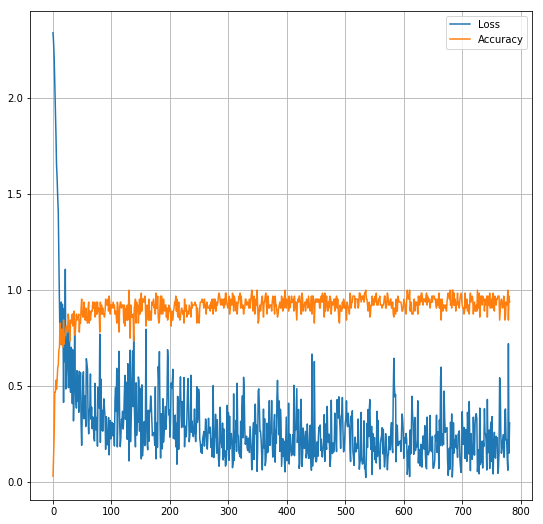

In [230]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,c.numpy()))
optim = torch.optim.SGD(model.parameters(), lr=lr)
fit3()

## 7.3 ลองใช้ Adam

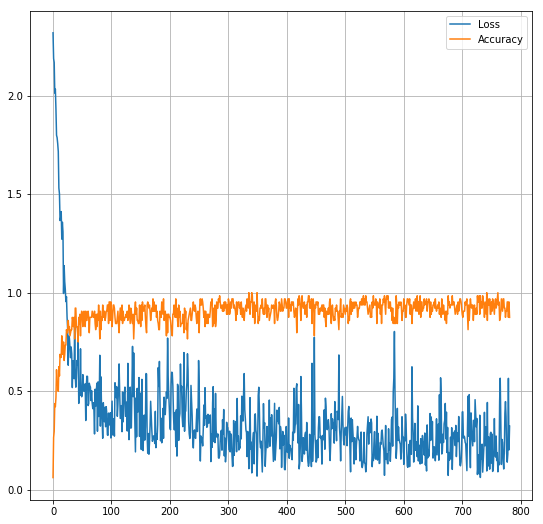

In [244]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh,c.numpy()))
optim = torch.optim.Adam(model.parameters(), lr=0.001)
fit3()

# 8. สรุป

1. เราได้ Refactor ทั้ง Model และ Training Loop แยกส่วน Parameter และ Optimization ให้แยกออกมา ทำให้โค้ด Clean มากขึ้น รองรับงานที่ซับซ้อนมากขึ้นในอนาคต
1. เราได้ Re-create PyTorch API ขึ้นมาจาก 0 เช่น nn.Module, nn.ModuleList, nn.Squential, optim, etc. ทำให้เราเข้าใจการเทรน Neual Network ในแต่ละขั้นตอนมากขึ้น
1. เรารู้ที่มาที่ไปของ API แต่ละตัว ทำให้สามารถเลือกใช้ API ที่เหมาะสมกับงาน สามารถออกแบบโมเดลที่ซับซ้อนมากขึ้น แก้ปัญหาได้หลากหลายมากขึ้น

# Credit 

* https://course.fast.ai/videos/?lesson=9
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/optim.html